# Libraries and helper functions

In [85]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_track_ids(sp, album_id, track_number):
    """
    Retrieve the track ID from a given album ID and track number.
    
    Parameters:
    - sp: The Spotify client object initialized using spotipy
    - album_id: The Spotify album ID (as a string)
    - track_number: The track number (1-based index) on the album
    
    Returns:
    - The track ID if found, None otherwise.
    """
    try:
        # Ensure the album ID is a string
        album_id = str(album_id)
        tracks = sp.album_tracks(album_id)['items']
        
        # Find the track by its track number
        for track in tracks:
            if track['track_number'] == track_number:
                return track['id']
        
        # Track number not found
        return None
    
    except Exception as e:
        print(f"An error occurred with album {album_id}: {e}")
        return None


# Integrate spotify scores into dataset

In [3]:
# Load the data
songs_df = pd.read_csv('../tswift_analysis_final.csv')
#drop rows where album_id is nan
songs_df = songs_df.dropna(subset=['album_id'])
songs_df.head(1)

,row_id,Album,Title,Lyrics,album_id,track_num.x,disc_num,duration,explicit,release_date,...,Comp.17,Comp.18,Comp.19,Comp.20,Comp.21,Comp.22,Comp.23,Comp.24,Comp.25,Comp.26
0,0,Taylor Swift,a perfectly good heart,Why would you wanna break A perfectly good hea...,7mzrIsaAjnXihW3InKjlC3,14.0,1.0,220146.0,False,2006-10-24,...,-2.206245,-1.173621,0.674648,-0.032709,-0.420456,-0.335645,-0.309538,-0.078925,0.100311,-0.022411


In [4]:
# start spotify api
client_id = '7226939d4c5e43ab969715d406ad11d9'
client_secret = '9e8ee07ae94f49928c65c59ffd4a3dec'
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(auth_manager=auth_manager)

In [5]:
# add track_id column to songs_df
songs_df['track_id'] = songs_df.apply(lambda row: get_track_ids(sp, row['album_id'], row['track_num.x']), axis=1)

In [17]:
def get_audio_features(sp, track_id):
    """
    Retrieve audio features of a track using the track ID and return them as a DataFrame.
    
    Parameters:
    - sp: The Spotify client object initialized using spotipy
    - track_id: The Spotify track ID
    
    Returns:
    - A DataFrame containing the audio features.
    """
    try:
        af = sp.audio_features(track_id)[0]
        if af:
            return pd.DataFrame([{
                'track_id': track_id, 
                'danceability': af['danceability'],
                'energy': af['energy'],
                'key': af['key'],
                'loudness': af['loudness'],
                'mode': af['mode'],
                'speechiness': af['speechiness'],
                'acousticness': af['acousticness'],
                'instrumentalness': af['instrumentalness'],
                'liveness': af['liveness'],
                'valence': af['valence'],
                'tempo': af['tempo'],
                'duration_ms': af['duration_ms'],
                'time_signature': af['time_signature']
            }])
        else:
            print(f"No audio features found for track {track_id}")
            return pd.DataFrame()
    
    except Exception as e:
        print(f"An error occurred for track {track_id}: {e}")
        return pd.DataFrame()

In [18]:
audio_features_df = pd.DataFrame(columns=['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                                          'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

for song in songs_df['track_id']:
    try:
        audio_features = sp.audio_features(song)[0]
        audio_features_df = pd.concat([audio_features_df, get_audio_features(sp, song)])
    except:
        pass

songs_df = pd.merge(songs_df, audio_features_df, on='track_id')

C:\Users\asarr\AppData\Local\Temp\ipykernel_20036\3644552197.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  audio_features_df = pd.concat([audio_features_df, get_audio_features(sp, song)])


In [119]:
songs_df.to_csv('tswift_analysis_with_audio_features.csv', index=False)

In [80]:
albums = list(set(songs_df['Album'].to_list()))
albums = ['Taylor Swift', 'Fearless (TV)', 'Speak Now (TV)', 'Red (TV)', '1989 (TV)', 'Reputation', 'Lover', 
          'folklore', 'evermore', 'Midnights', 'TTPD']
albums

['Taylor Swift',
 'Fearless (TV)',
 'Speak Now (TV)',
 'Red (TV)',
 '1989 (TV)',
 'Reputation',
 'Lover',
 'folklore',
 'evermore',
 'Midnights',
 'TTPD']

In [81]:
#describe the data
songs_af = songs_df[songs_df['Album'].isin(albums)][['Album', 'Title', 'danceability', 'energy', 'key', 'loudness',
                                                     'mode', 'speechiness', 'acousticness', 'instrumentalness',
                                                     'liveness', 'valence', 'tempo']]
songs_af

,Album,Title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Taylor Swift,a perfectly good heart,0.483,0.751,4,-5.726,1,0.0365,0.00349,0,0.128,0.268,156.092
1,Taylor Swift,a place in this world,0.576,0.777,9,-2.881,1,0.0324,0.05100,0,0.320,0.428,115.028
2,Taylor Swift,cold as you,0.418,0.482,5,-5.769,1,0.0266,0.21700,0,0.123,0.261,175.558
3,Taylor Swift,i'm only me when i'm with you,0.563,0.934,8,-3.629,1,0.0646,0.00452,0.000807,0.103,0.518,143.964
4,Taylor Swift,invisible,0.612,0.394,7,-5.723,1,0.0243,0.63700,0,0.147,0.233,96.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,TTPD,loml,0.423,0.272,0,-12.560,1,0.0489,0.85800,0,0.108,0.195,78.539
353,TTPD,I Can Do It With A Broken Heart,0.701,0.751,0,-8.390,1,0.0502,0.12300,0,0.150,0.220,129.994
354,TTPD,The Smallest Man Who Ever Lived,0.426,0.410,10,-9.083,1,0.0581,0.52000,0,0.338,0.263,142.377
355,TTPD,The Alchemy,0.640,0.421,0,-8.802,1,0.0273,0.42200,0,0.103,0.353,100.056


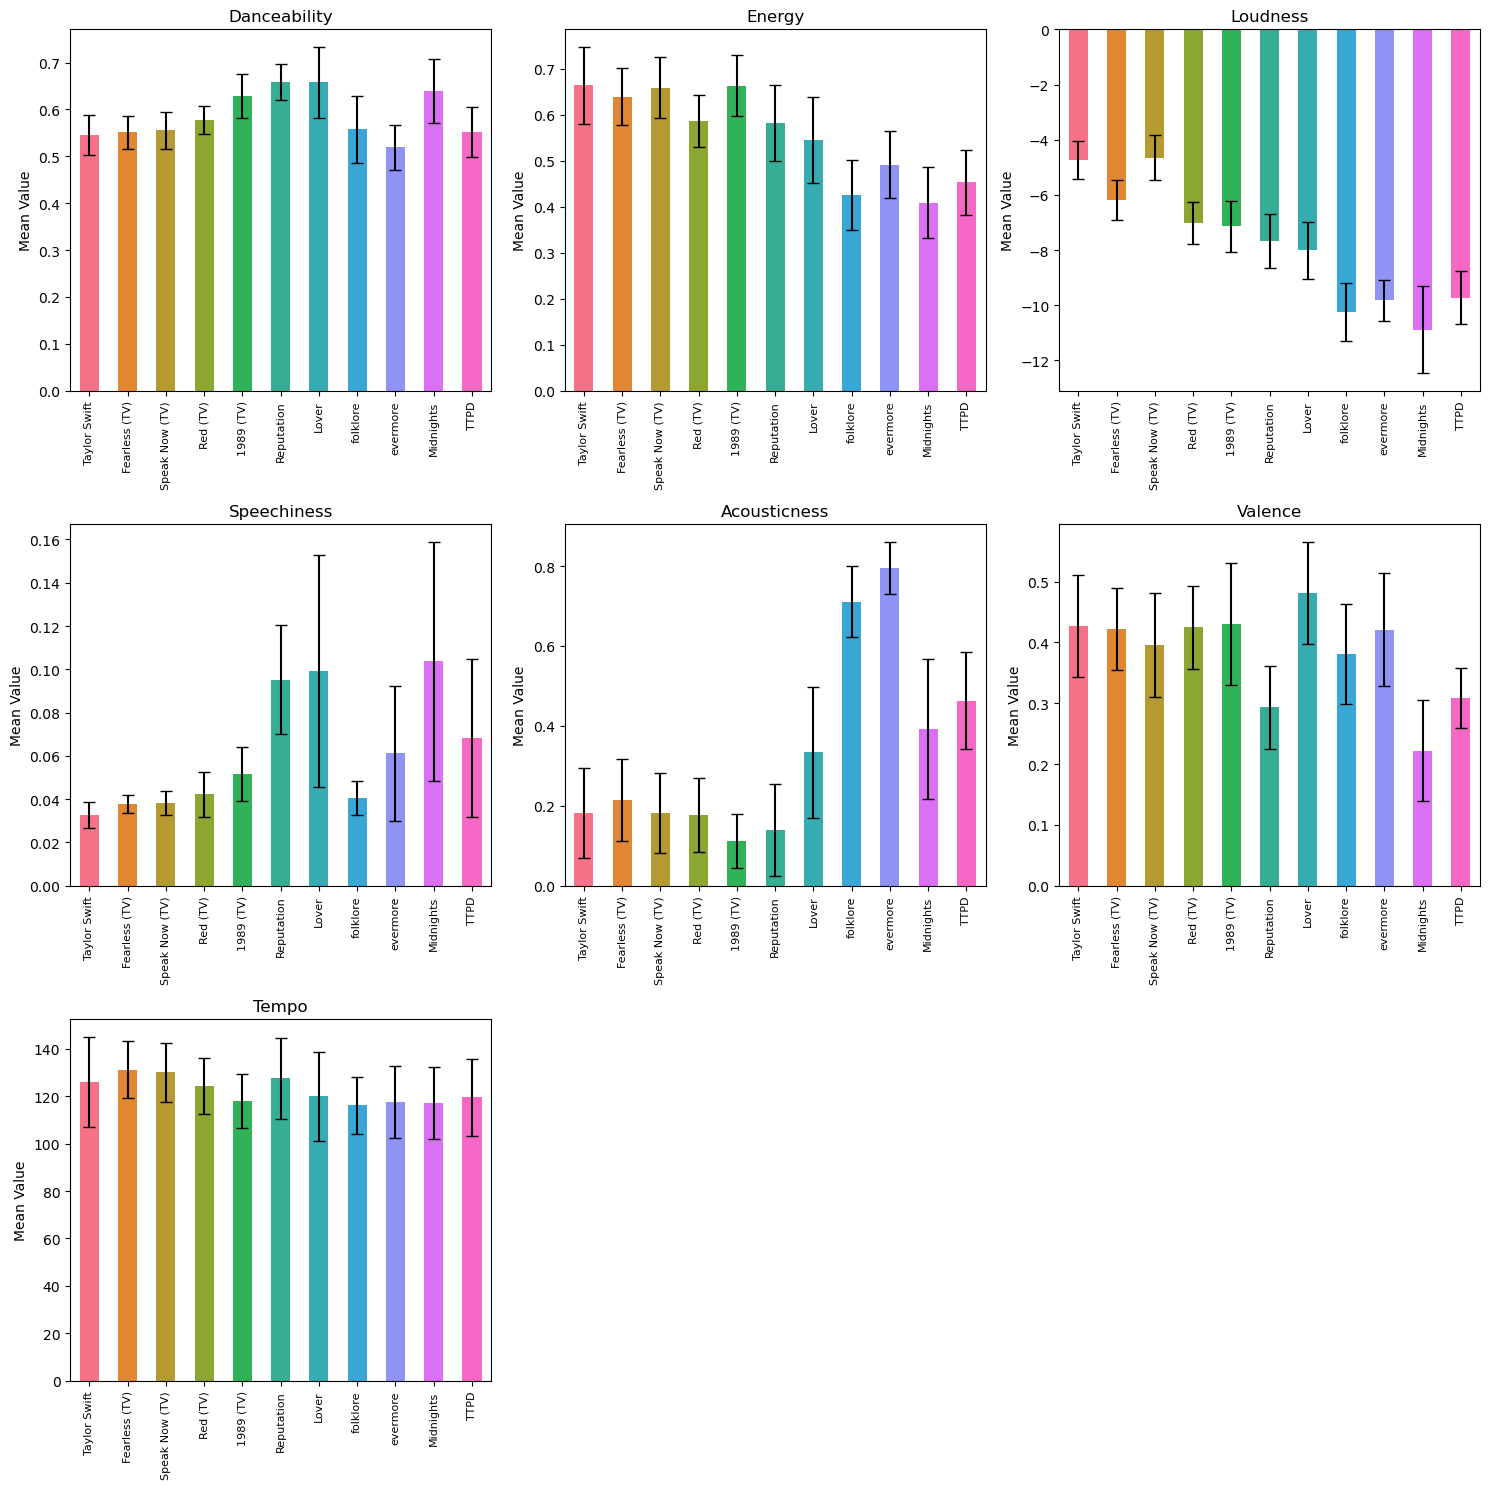

In [99]:
from scipy.stats import norm

numeric_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence', 'tempo']
mean_values_by_album = songs_af.groupby("Album")[numeric_columns].mean().reindex(albums)
std_values_by_album = songs_af.groupby("Album")[numeric_columns].std().reindex(albums)
n_values_by_album = songs_af.groupby("Album").size().reindex(albums).values

z_score = norm.ppf(0.975)  # For 95% confidence level
se_values_by_album = std_values_by_album / np.sqrt(n_values_by_album[:, np.newaxis])
ci_error = z_score * se_values_by_album

palette = sns.color_palette("husl", len(albums))
color_map = {album: palette[i] for i, album in enumerate(albums)}

num_measures = len(numeric_columns)
grid_size = int(np.ceil(np.sqrt(num_measures)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, measure in enumerate(numeric_columns):
    if i < len(axes):
        colors = [color_map[album] for album in mean_values_by_album.index]
        mean_values_by_album[measure].plot(kind='bar', ax=axes[i], color=colors, 
                                           yerr=ci_error[measure], capsize=4)
        axes[i].set_title(measure.capitalize())
        axes[i].set_ylabel("Mean Value")
        axes[i].set_xlabel("")
        axes[i].set_xticklabels(mean_values_by_album.index, rotation=90, fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

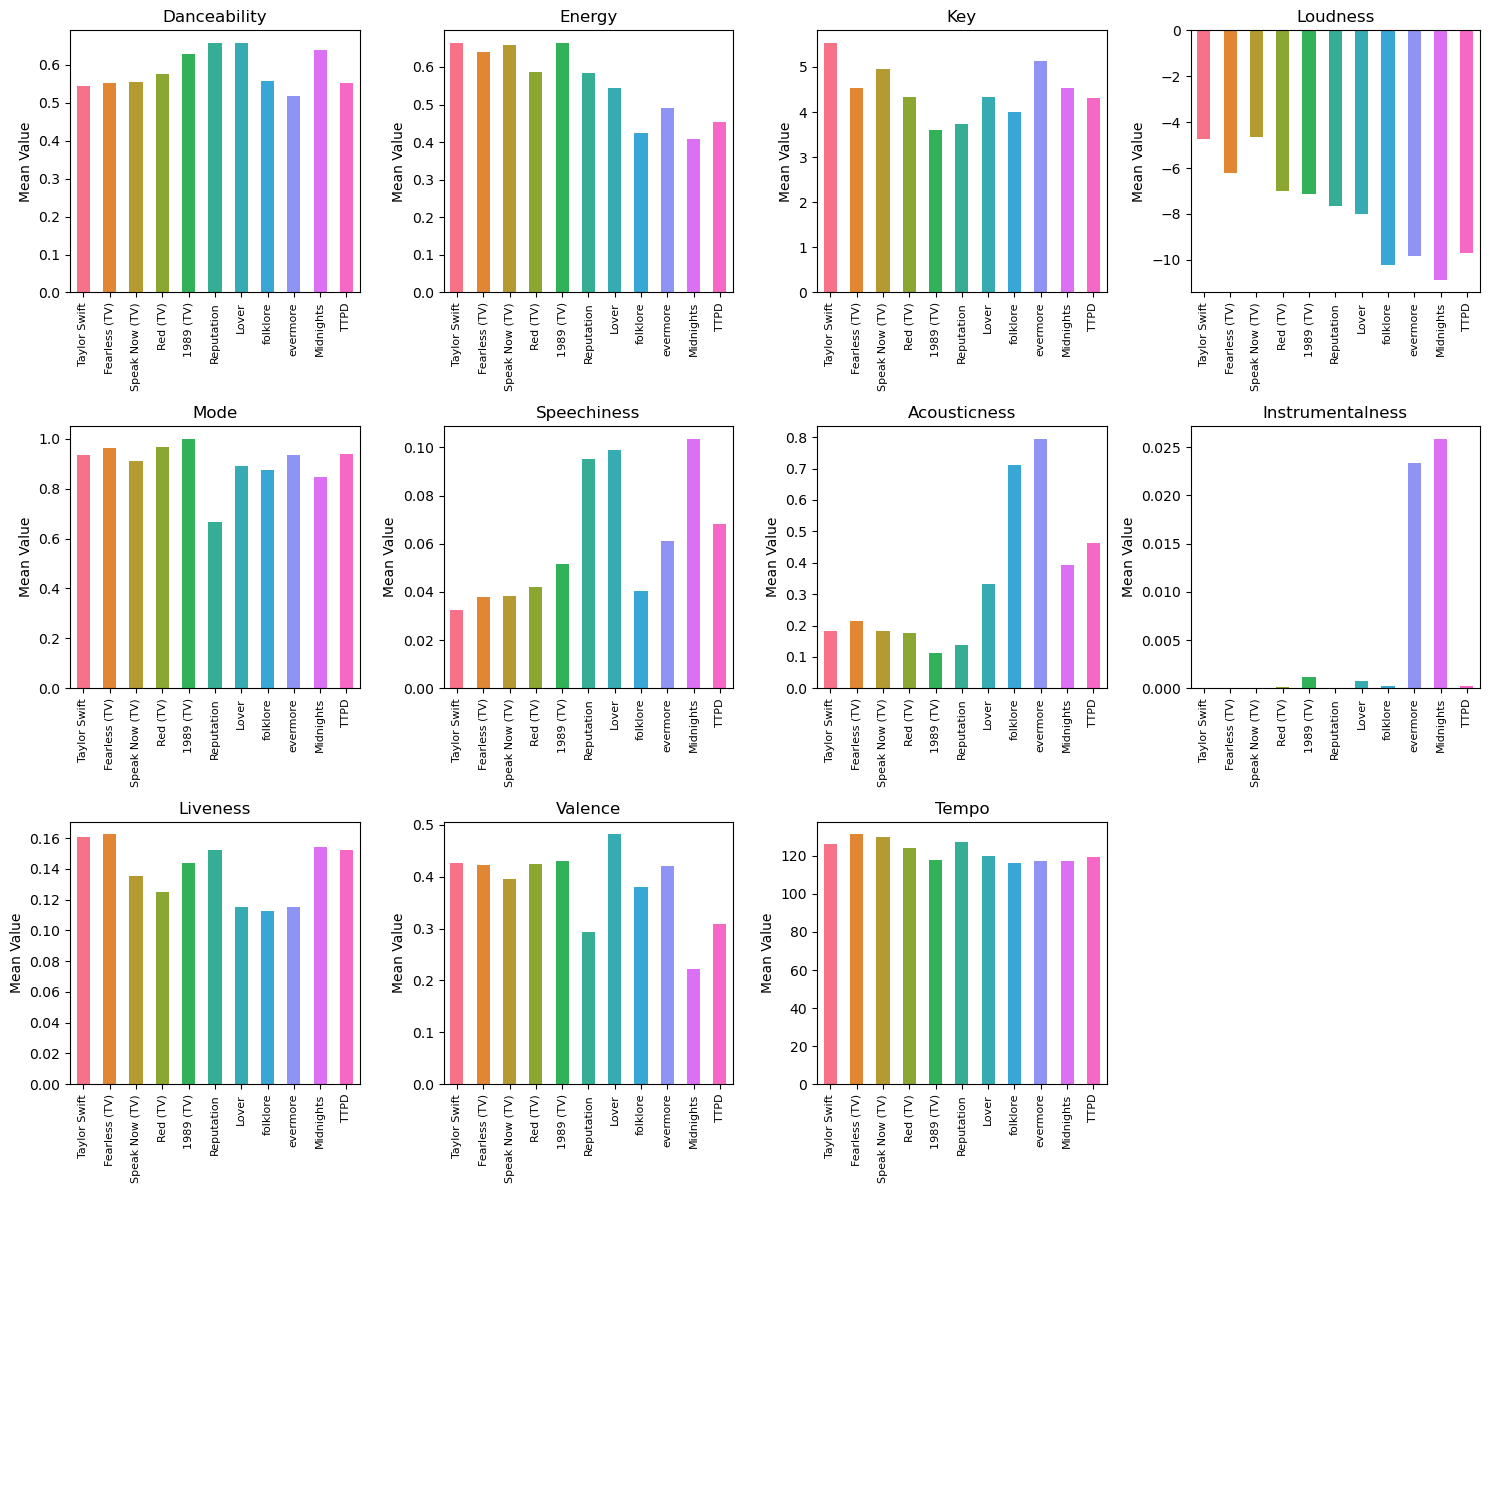

In [90]:
numeric_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
mean_values_by_album = songs_af.groupby("Album")[numeric_columns].mean()
mean_values_by_album = mean_values_by_album.reindex(albums)

palette = sns.color_palette("husl", len(albums))
color_map = {album: palette[i] for i, album in enumerate(albums)}

num_measures = len(numeric_columns)
grid_size = int(np.ceil(np.sqrt(num_measures)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, measure in enumerate(numeric_columns):
    if i < len(axes):
        colors = [color_map[album] for album in mean_values_by_album.index]
        mean_values_by_album[measure].plot(kind='bar', ax=axes[i], color=colors)
        axes[i].set_title(measure.capitalize())
        axes[i].set_ylabel("Mean Value")
        axes[i].set_xlabel("")
        axes[i].set_xticklabels(mean_values_by_album.index, rotation=90, fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

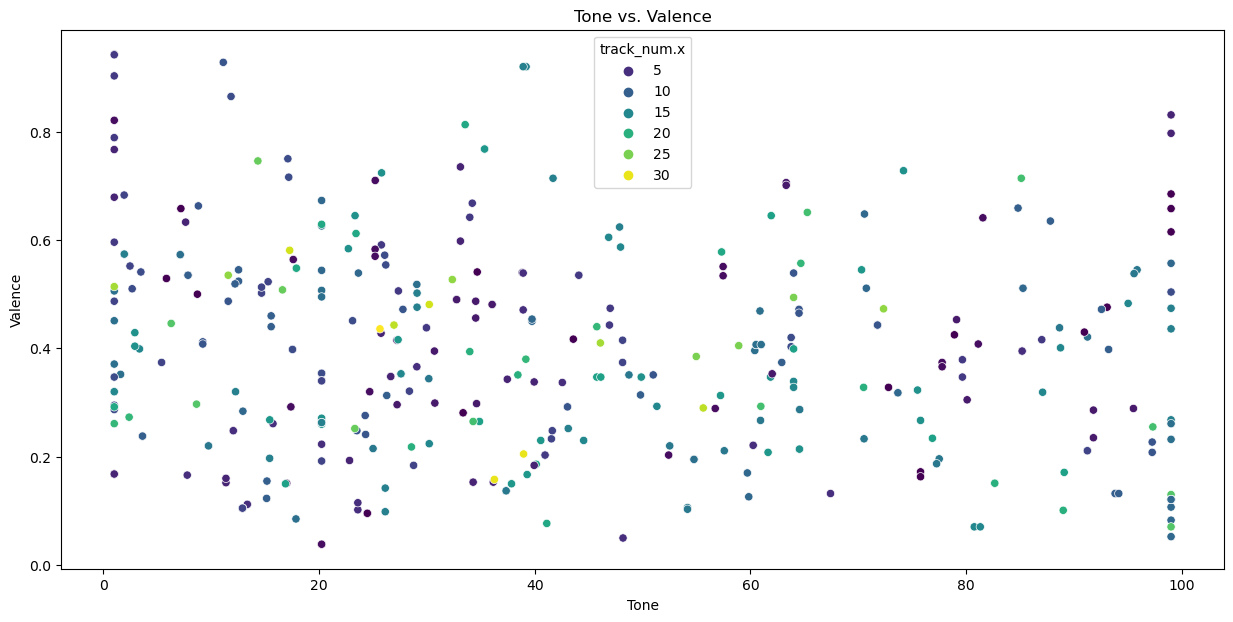

In [118]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=songs_df, x='Tone', y='valence', hue='track_num.x', palette='viridis')
# for index, row in songs_df[songs_df['Album'] == 'TTPD'].iterrows():
#     plt.text(row['Tone'], row['valence'], row['Title'], fontsize=9, ha='left')
plt.title("Tone vs. Valence")
plt.xlabel("Tone")
plt.ylabel("Valence")
plt.show()

In [114]:
songs_af['valence'].mean()

0.39181796116504847

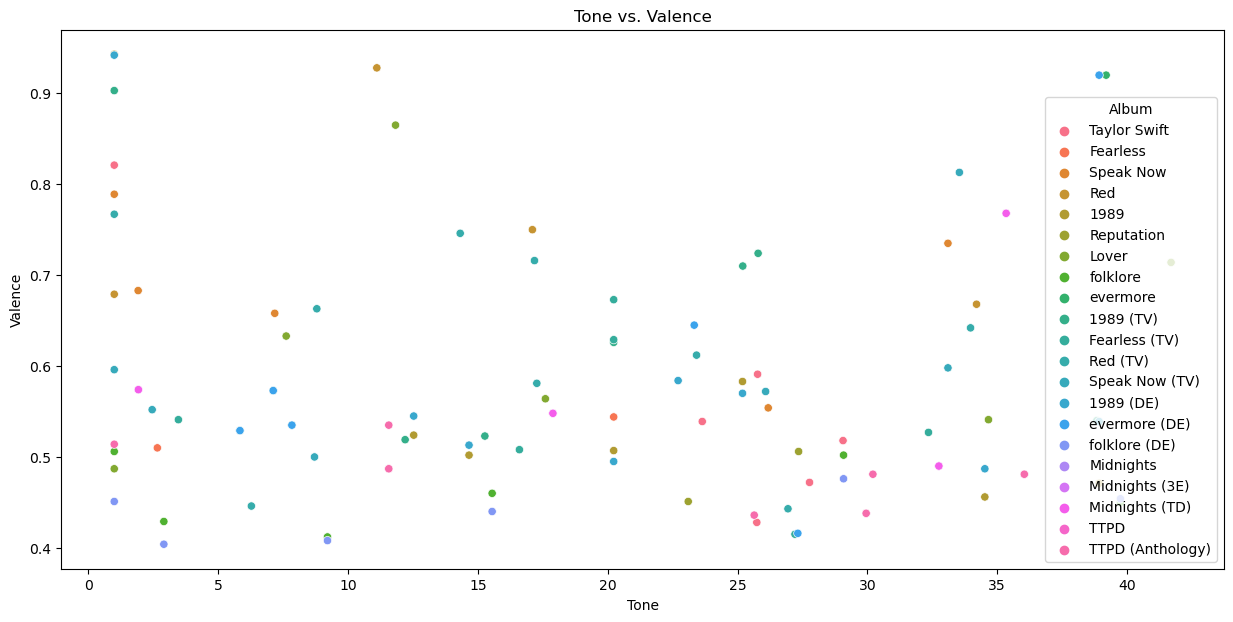

In [116]:
sad_bops = songs_df[(songs_df['Tone'] < 43) & (songs_df['valence'] > 0.4)]

#create a scatterplot of Tone and Valence
plt.figure(figsize=(15, 7))
sns.scatterplot(data=sad_bops, x='Tone', y='valence', hue='Album')
# for index, row in sad_bops.iterrows():
#     plt.text(row['Tone'], row['valence'], row['Title'], fontsize=9, ha='left')
plt.title("Tone vs. Valence")
plt.xlabel("Tone")
plt.ylabel("Valence")
plt.show()

In [117]:
sad_bops

,row_id,Album,Title,Lyrics,album_id,track_num.x,disc_num,duration,explicit,release_date,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1,1,Taylor Swift,a place in this world,"I don't know what I want, so don't ask me 'Cau...",7mzrIsaAjnXihW3InKjlC3,4.0,1.0,199200.0,False,2006-10-24,...,-2.881,1,0.0324,0.05100,0,0.3200,0.428,115.028,199200,4
3,3,Taylor Swift,i'm only me when i'm with you,Friday night beneath the stars In a field behi...,7mzrIsaAjnXihW3InKjlC3,12.0,1.0,213053.0,False,2006-10-24,...,-3.629,1,0.0646,0.00452,0.000807,0.1030,0.518,143.964,213053,4
6,6,Taylor Swift,our song,I was ridin' shotgun with my hair undone In th...,7mzrIsaAjnXihW3InKjlC3,11.0,1.0,201106.0,False,2006-10-24,...,-4.931,1,0.0303,0.11100,0,0.3290,0.539,89.011,201107,4
7,7,Taylor Swift,picture to burn,"State the obvious, I didn't get my perfect fan...",7mzrIsaAjnXihW3InKjlC3,2.0,1.0,173066.0,False,2006-10-24,...,-2.098,1,0.0323,0.17300,0,0.0962,0.821,105.586,173067,4
8,8,Taylor Swift,should've said no,It's strange to think the songs we used to sin...,7mzrIsaAjnXihW3InKjlC3,9.0,1.0,242200.0,False,2006-10-24,...,-3.771,0,0.0289,0.01030,0,0.1960,0.472,167.964,242200,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,376,TTPD (Anthology),Guilty As Sin,"Drowning in the Blue Nile, He sent me ""Downtow...",5H7ixXZfsNMGbIE5OBSpcb,9.0,1.0,254.0,False,2024-04-19,...,-8.374,1,0.0261,0.60700,0,0.0921,0.487,94.950,254366,3
382,393,TTPD (Anthology),The Prophecy,"Hand on the throttle, Thought I caught lightni...",5H7ixXZfsNMGbIE5OBSpcb,26.0,2.0,249.0,False,2024-04-19,...,-10.359,1,0.0472,0.82500,0.000003,0.3080,0.535,167.927,249807,4
383,394,TTPD (Anthology),Cassandra,"I was in my new house placing daydreams, Patch...",5H7ixXZfsNMGbIE5OBSpcb,27.0,2.0,240.0,True,2024-04-19,...,-9.879,1,0.0595,0.80600,0,0.1370,0.514,139.963,240206,4
385,396,TTPD (Anthology),The Bolter,"By all accounts, she almost drowned, When she ...",5H7ixXZfsNMGbIE5OBSpcb,29.0,2.0,238.0,True,2024-04-19,...,-7.978,1,0.0492,0.63800,0,0.1310,0.481,183.694,238242,4
